# Предсказание коэффициента восстановления золота из золотосодержащей руды.

Необходимо разработать прототип модели машинного обучения, которая предсказывает коэффициент восстановления золота из золотосодержащей руды. Предоставленные заказчиком исходные данные содержат  параметры добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Описание данных


**Технологический процесс**

   - Rougher feed — исходное сырье
   - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
      - Xanthate **— ксантогенат (промотер, или активатор флотации);
      - Sulphate — сульфат (на данном производстве сульфид натрия);
      - Depressant — депрессант (силикат натрия).
   - Rougher process (англ. «грубый процесс») — флотация
   - Rougher tails — отвальные хвосты
   - Float banks — флотационная установка
   - Cleaner process — очистка
   - Rougher Au — черновой концентрат золота
   - Final Au — финальный концентрат золота
   
   
**Параметры этапов**

   - air amount — объём воздуха
   - fluid levels — уровень жидкости
   - feed size — размер гранул сырья
   - feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

   - rougher — флотация
   - primary_cleaner — первичная очистка
   - secondary_cleaner — вторичная очистка
   - final — финальные характеристики
   
Возможные значения для блока [тип_параметра]:

   - input — параметры сырья
   - output — параметры продукта
   - state — параметры, характеризующие текущее состояние этапа
   - calculation — расчётные характеристики

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

## 1. Подготовка данных

### 1.1. Первичное изучение данных.

In [2]:
gold_full = pd.read_csv('C:/Users/Olga/datasets/gold_recovery_full_new.csv')
gold_train = pd.read_csv('C:/Users/Olga/datasets/gold_recovery_train_new.csv')
gold_test = pd.read_csv('C:/Users/Olga/datasets/gold_recovery_test_new.csv')

In [3]:
def data_checkup(data):
    display(data.head(10))
    print()
    data.info()
    print()
    print('Количество явных дубликатов в датасете:', data.duplicated().sum())
    print()
    print('Доля пропусков в датасете:', round(((data.isna().sum()).sum()/len(data)),2))
    print()
    print()
    print('Столбцы с долей пропусков более 0.5%:')
    print()
    for column in data.columns:
        if data[column].isna().sum() / len(data) >= 0.005:
            print('Количество пропусков в столбце:', column,' - ', data[column].isna().sum())

    print('Проверка на мультиколлинеарность:')
    display(data.corr().style.background_gradient(axis=None, cmap='YlOrRd'))
    

In [4]:
data_checkup(gold_full)

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   
5  2016-01-15 05:00:00                     6.482968   
6  2016-01-15 06:00:00                     6.533849   
7  2016-01-15 07:00:00                     6.130823   
8  2016-01-15 08:00:00                     5.834140   
9  2016-01-15 09:00:00                     5.687063   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   
5                    10.049416                      5.480257   
6                    10.058141                      4.569100   
7                     9.935481                      4.389813   
8                    10.071156                      4.876389   
9                     9.980404                      5.282514   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   
5                    41.633678              69.465816             10.182708   
6                    41.995316              69.300835             10.304598   
7                    42.452727              70.230976             10.443288   
8                    43.404078              69.688595             10.420140   
9                    43.235220              70.279619             10.487013   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   
5              0.664118              16.999638              1.918586  ...   
6              0.807342              16.723575              2.058913  ...   
7              0.949346              16.689959              2.143437  ...   
8              1.065453              17.201948              2.209881  ...   
9              1.159805              17.483979              2.209593  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   
5                                 13.938497   
6                                 14.046819   
7                                 13.974691   
8                                 13.964030   
9                                 13.989632   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   
5                                 -500.970168   
6                                 -500.971133   
7                                 -501.819696   
8                             


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant            

In [5]:
data_checkup(gold_train)

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   
5  2016-01-15 05:00:00                     6.482968   
6  2016-01-15 06:00:00                     6.533849   
7  2016-01-15 07:00:00                     6.130823   
8  2016-01-15 08:00:00                     5.834140   
9  2016-01-15 09:00:00                     5.687063   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   
5                    10.049416                      5.480257   
6                    10.058141                      4.569100   
7                     9.935481                      4.389813   
8                    10.071156                      4.876389   
9                     9.980404                      5.282514   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   
5                    41.633678              69.465816             10.182708   
6                    41.995316              69.300835             10.304598   
7                    42.452727              70.230976             10.443288   
8                    43.404078              69.688595             10.420140   
9                    43.235220              70.279619             10.487013   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   
5              0.664118              16.999638              1.918586  ...   
6              0.807342              16.723575              2.058913  ...   
7              0.949346              16.689959              2.143437  ...   
8              1.065453              17.201948              2.209881  ...   
9              1.159805              17.483979              2.209593  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   
5                                 13.938497   
6                                 14.046819   
7                                 13.974691   
8                                 13.964030   
9                                 13.989632   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   
5                                 -500.970168   
6                                 -500.971133   
7                                 -501.819696   
8                             


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant            

In [6]:
data_checkup(gold_test)

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   
5  2016-09-01 05:59:59                     168.485085   
6  2016-09-01 06:59:59                     144.133440   
7  2016-09-01 07:59:59                     133.513396   
8  2016-09-01 08:59:59                     133.735356   
9  2016-09-01 09:59:59                     126.961069   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   
5                          8.817007                         7.420000   
6                          7.924610                         7.420000   
7                          8.055252                         6.988000   
8                          7.999618                         6.935000   
9                          8.017856                         7.030000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   
5                        0.791191                             1402.826803   
6                        0.788838                             1398.252401   
7                        0.801871                             1401.669677   
8                        0.789329                             1402.358981   
9                        0.805298                             1400.816120   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   
5                               -499.299521   
6                               -499.748672   
7                               -501.777839   
8                               -499.981597   
9                               -499.014158   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   
5                             1401.511119   
6                             1393.255503   
7                             1400.754446   
8                             1400.985954   
9                             1399.975401   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   
5                               -499.205357   
6                               -499.195380   
7                               -502.514024   
8                               -496.802968   
9                               -499.570552   

   primary_cleaner.state.floatbank8_c_air  ...  \
0                             1400.102998  ...   
1                             1396.151033  ...   
2                             1398.075709  ...   
3                


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.i

**ВЫВОД:**

В результате первичного анализа данных выяснили следующее:

   - В данных имеются пропущенные значения
   - Дубликаты в данных отсутствуют
   - Типы данных корректны и не требуют изменения, за исключением столбца `date`.
   - В данных есть сильно коррелирующие между собой столбцы.

### 1.2. Проверка правильности расчета эффективности обогащения.

Прежде чем строить модель, необходимо проверить, что эффективность обогащения рассчитана правильно. 
Для этого нужно использовать обучающую выборку и сравнить полученные результаты с фактическими значениями признака. Если результаты отличаются, это может указывать на ошибку в расчетах или на то, что обогащение не дает желаемого эффекта - следовательно, прогноз, полученный на таких данных априори будет ошибочным. 

Вычислим эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`. Далее, найдем MAE между расчётами и значением признака.

Эффективность обогащения рассчитывается по формуле, приведенной ниже.

In [7]:
display(Image(url='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg', width=500))

где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём, важен не только финальный продукт, но и черновой концентрат.

Чтобы найти необходимые переменные, выведем все столбцы с данными по золоту из обучающей выборки

In [8]:
for column in gold_train:
    if '_au' in column:
        print(column)

final.output.concentrate_au
final.output.tail_au
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.input.feed_au
rougher.output.concentrate_au
rougher.output.tail_au
secondary_cleaner.output.tail_au


In [9]:
# C — доля золота в концентрате после флотации/очистки:
C = gold_train['rougher.output.concentrate_au']

# F — доля золота в сырье/концентрате до флотации/очистки:
F = gold_train['rougher.input.feed_au']

# T — доля золота в отвальных хвостах после флотации/очистки:
T = gold_train['rougher.output.tail_au']

In [10]:
calculated_recovery = ((C * (F - T)) / (F * (C - T))) * 100

In [11]:
print('Абсолютная средняя ошибка =', mean_absolute_error(gold_train['rougher.output.recovery'], calculated_recovery))

Абсолютная средняя ошибка = 9.682896147825551e-15


**ВЫВОД:**

Проведена оценка MAE между исходным и расчётным значением эффективности обогащения. 
Значение МАЕ ничтожно мало и стремится к нулю, следовательно, эффективность обогащения рассчитана правильно.

### 1.3. Анализ признаков, недоступных в тестовой выборке.

При первичном анализе выявлено, что в тестовой выборке отсутствует ряд признаков, которые есть в обучающем наборе. Найдем все такие признаки.

In [12]:
list_col=[]

for column in gold_train:
    if column not in gold_test:
        list_col.append(column)
print(list_col)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

In [13]:
len(list_col)

34

In [14]:
len(gold_test.columns)

53

In [15]:
len(gold_train.columns)

87

In [16]:
calculation_count=0
output_count=0
input_count=0
state_count=0

for column in gold_test:
    if 'calculation' in column:
        calculation_count += 1
    if 'output' in column:
        output_count += 1
    if 'input' in column:
        input_count += 1
    if 'state' in column:
        state_count += 1
print('Количество признаков типа calculation:', calculation_count)
print('Количество признаков типа output:', output_count)
print('Количество признаков типа calculation:', input_count)
print('Количество признаков типа calculation:', state_count)


Количество признаков типа calculation: 0
Количество признаков типа output: 0
Количество признаков типа calculation: 14
Количество признаков типа calculation: 38


**ВЫВОД:** 

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 

В тестовой выборке отсутствуют признаки типов calculation(расчетные характеристики) и output(параметры продукта на выходе из процесса). И это логично, поскольку смысл моделирования процесса как раз в том, чтобы на основе данных о сырье с достаточной точностью предсказать характеристики продукта после производственного процесса. Наличие в тестовой выборке признаков типа calculation и output - это своего рода утечка целевого признака, т.е. в такой ситуации невозможно было бы объективно оценить построенную модель. 

### 1.4. Предобработка данных.

В рамках предобработки необходимо: 

  1. Заполнить пропуски в данных. 
  
В задании есть следующее условие: "Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи." Опираясь на это условие здесь уместно использовать стратегию заполнения forward fill: с помощью метода ffill(), который заполняет пропуски значениями из предыдущей строки.  

  2. Привести столбцы `date` к типу datetime.
  
  
  3. Решить вопрос с мультиколлинеарностью в обучающей выборке.
  
  
  4. Добавить в тестовую выборку целевые признаки. По условию нужно спрогнозировать сразу две величины:
  
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

  Соответственно, именно эти два столбца необходимо добавить в тестовую выборку.


In [17]:
# Заполняем пропуски во всех трех датасетах:

gold_full = gold_full.ffill()
gold_train = gold_train.ffill()
gold_test = gold_test.ffill()

# Проверяем:

print('Количество пропусков после заполнения для gold_full:',(gold_full.isna().sum()).sum())
print('Количество пропусков после заполнения для gold_train:',(gold_train.isna().sum()).sum())
print('Количество пропусков после заполнения для gold_test:',(gold_test.isna().sum()).sum())

Количество пропусков после заполнения для gold_full: 0
Количество пропусков после заполнения для gold_train: 0
Количество пропусков после заполнения для gold_test: 0


In [18]:
print('Количество явных дубликатов в датасете:', gold_full.duplicated().sum())
print('Количество явных дубликатов в датасете:', gold_train.duplicated().sum())
print('Количество явных дубликатов в датасете:', gold_test.duplicated().sum())

Количество явных дубликатов в датасете: 0
Количество явных дубликатов в датасете: 0
Количество явных дубликатов в датасете: 0


In [19]:
# Приводим столбцы `date` к типу datetime:

gold_full['date'] = pd.to_datetime(gold_full['date'])
gold_train['date'] = pd.to_datetime(gold_train['date'])
gold_test['date'] = pd.to_datetime(gold_test['date'])

Мультиколлинеарность может негативно сказаться на результатах линейных моделей. Выведем словарь пар коррелирующих столбцов, и затем создадим два дополнительных обучающих датафрейма, в одном из которых не будет ключей словаря, а в другом - его значений. Далее, при обучении моделей, помимо основного трэйн-сета, передадим линейным моделям эти датасеты и сравним результаты.

In [20]:
corr_train = gold_train.corr().unstack().sort_values(kind="quicksort")
corr_train_2 = corr_train.loc[lambda x : (((x < -0.75) & (x > -1)) | ((x > 0.75) & (x < 1)))]
corr_train_2

secondary_cleaner.state.floatbank5_b_air  secondary_cleaner.state.floatbank3_a_air    0.751101
secondary_cleaner.state.floatbank3_a_air  secondary_cleaner.state.floatbank5_b_air    0.751101
rougher.state.floatbank10_f_air           rougher.state.floatbank10_c_air             0.757465
rougher.state.floatbank10_c_air           rougher.state.floatbank10_f_air             0.757465
rougher.output.tail_pb                    rougher.output.tail_au                      0.759673
                                                                                        ...   
rougher.state.floatbank10_d_level         rougher.state.floatbank10_c_level           0.987670
rougher.state.floatbank10_c_level         rougher.state.floatbank10_b_level           0.988065
rougher.state.floatbank10_b_level         rougher.state.floatbank10_c_level           0.988065
rougher.state.floatbank10_f_level         rougher.state.floatbank10_e_level           0.988426
rougher.state.floatbank10_e_level         rougher.

In [21]:
multicorr_to_drop = {}

for ind in corr_train_2.index:
    if ind[0] not in multicorr_to_drop:
        if ind[0] not in multicorr_to_drop.values():
            if ind[1] not in multicorr_to_drop:
                    if ind[1] not in multicorr_to_drop.values():
                        multicorr_to_drop.update({ind[0]:ind[1]})

In [22]:
multicorr_to_drop

{'secondary_cleaner.state.floatbank5_b_air': 'secondary_cleaner.state.floatbank3_a_air',
 'rougher.state.floatbank10_f_air': 'rougher.state.floatbank10_c_air',
 'rougher.output.tail_pb': 'rougher.output.tail_au',
 'secondary_cleaner.state.floatbank5_a_air': 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level': 'secondary_cleaner.state.floatbank5_a_level',
 'rougher.input.feed_pb': 'final.output.tail_pb',
 'rougher.input.floatbank11_sulfate': 'rougher.input.floatbank10_sulfate',
 'rougher.state.floatbank10_e_air': 'rougher.state.floatbank10_b_air',
 'rougher.input.feed_au': 'rougher.input.feed_ag',
 'secondary_cleaner.state.floatbank2_b_air': 'secondary_cleaner.state.floatbank2_a_air',
 'rougher.output.concentrate_au': 'rougher.output.concentrate_sol',
 'rougher.input.floatbank11_xanthate': 'rougher.input.floatbank10_xanthate',
 'secondary_cleaner.state.floatbank2_b_level': 'secondary_cleaner.state.floatbank2_a_level',
 'primary_cleaner.state.floatba

In [23]:
multicorr_to_drop.values()

dict_values(['secondary_cleaner.state.floatbank3_a_air', 'rougher.state.floatbank10_c_air', 'rougher.output.tail_au', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'final.output.tail_pb', 'rougher.input.floatbank10_sulfate', 'rougher.state.floatbank10_b_air', 'rougher.input.feed_ag', 'secondary_cleaner.state.floatbank2_a_air', 'rougher.output.concentrate_sol', 'rougher.input.floatbank10_xanthate', 'secondary_cleaner.state.floatbank2_a_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.output.tail_pb', 'rougher.state.floatbank10_b_level', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.state.floatbank10_e_level'])

In [24]:
gold_train_multicorr_drop_1 = gold_train.drop(['secondary_cleaner.state.floatbank3_a_air', 'rougher.state.floatbank10_c_air',\
                                               'rougher.output.tail_au', 'secondary_cleaner.state.floatbank4_a_air',\
                                               'secondary_cleaner.state.floatbank5_a_level', 'final.output.tail_pb',\
                                               'rougher.input.floatbank10_sulfate', 'rougher.state.floatbank10_b_air',\
                                               'rougher.input.feed_ag', 'secondary_cleaner.state.floatbank2_a_air',\
                                               'rougher.output.concentrate_sol', 'rougher.input.floatbank10_xanthate',\
                                               'secondary_cleaner.state.floatbank2_a_level',\
                                               'primary_cleaner.state.floatbank8_c_air',\
                                               'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.output.tail_pb',\
                                               'rougher.state.floatbank10_b_level',\
                                               'rougher.calculation.floatbank11_sulfate_to_au_feed',\
                                               'rougher.state.floatbank10_e_level'], axis=1)

In [25]:
multicorr_to_drop.keys()

dict_keys(['secondary_cleaner.state.floatbank5_b_air', 'rougher.state.floatbank10_f_air', 'rougher.output.tail_pb', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'rougher.input.feed_pb', 'rougher.input.floatbank11_sulfate', 'rougher.state.floatbank10_e_air', 'rougher.input.feed_au', 'secondary_cleaner.state.floatbank2_b_air', 'rougher.output.concentrate_au', 'rougher.input.floatbank11_xanthate', 'secondary_cleaner.state.floatbank2_b_level', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.output.tail_ag', 'rougher.state.floatbank10_f_level', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.state.floatbank10_d_level'])

In [26]:
gold_train_multicorr_drop_2 = gold_train.drop(['secondary_cleaner.state.floatbank5_b_air', 'rougher.state.floatbank10_f_air',\
                                               'rougher.output.tail_pb', 'secondary_cleaner.state.floatbank5_a_air',\
                                               'secondary_cleaner.state.floatbank4_a_level', 'rougher.input.feed_pb',\
                                               'rougher.input.floatbank11_sulfate', 'rougher.state.floatbank10_e_air',\
                                               'rougher.input.feed_au', 'secondary_cleaner.state.floatbank2_b_air',\
                                               'rougher.output.concentrate_au', 'rougher.input.floatbank11_xanthate',\
                                               'secondary_cleaner.state.floatbank2_b_level',\
                                               'primary_cleaner.state.floatbank8_a_air',\
                                               'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.output.tail_ag',\
                                               'rougher.state.floatbank10_f_level',\
                                               'rougher.calculation.floatbank10_sulfate_to_au_feed',\
                                               'rougher.state.floatbank10_d_level'], axis=1)

Получили два дополнительных обучающих набора: `gold_train_multicorr_drop_1` и `gold_train_multicorr_drop_2`, из которых удалены по две различные комбинации коррелирующих признаков. Впоследствии, при моделировании, помимо основного - полного набора призников - в качестве эксперимента используем эти дополнительные датасеты для обучения линейной модели и сравним результаты.

In [27]:
# Добавляем в тестовую выборку целевые признаки из gold_full

gold_test = gold_test.merge(gold_full[['date','rougher.output.recovery', 'final.output.recovery']], how='left', on='date')
gold_test.head()

date  primary_cleaner.input.sulfate  \
0 2016-09-01 00:59:59                     210.800909   
1 2016-09-01 01:59:59                     215.392455   
2 2016-09-01 02:59:59                     215.259946   
3 2016-09-01 03:59:59                     215.336236   
4 2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   

   primary_cleaner.state.floatbank8_c_air  ...  \
0                             1400.102998  ...   
1                             1396.151033  ...   
2                             1398.075709  ...   
3                             1400.129303  ...   
4                             1402.172226  ...   

   secondary_cleaner.state.floatbank4_b_air  \
0                                  8.016656   
1                                  8.130979   
2                                  8.096893   
3                                  8.074946   
4                                  8.054678   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -501.289139   
1                                 -499.634209   
2                                 -500.827423   
3                                 -499.474407   
4                                 -500.397500   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  7.946562   
1                                  7.958270   
2                                  8.071056   
3                                  7.897085   
4                                  8.107890   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -432.317850   
1                                 -525.839648   
2                                 -500.801673   
3                                 -500.868509   
4                                 -509.526725   

   secondary_cleaner.state.floatbank5_b_air  \
0                                  4.872511   
1                                  4.878850   
2                                  4.905125   
3                                  4.931400   
4                                  4.957674   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.037437   
1                                 -500.162375   
2                                 -499.828510   
3          

In [28]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
date                                          5290 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
ro

**ВЫВОД:** 

В качестве предобработки данных были проведены следующие действия:

 - Заполнены пропуски.
 - Столбцы с датами приведены к соответствующему типу.
 - Признаки в обучающей выборке проверены на мультиколлинеарность; подготовлено два альтернативных обучающих датасета, в которых удалны сильнокоррелирующие признаки.
 - В тестовую выборку добавлены целевые признаки.

Данные готовы к анализу.

## 2. Анализ данных.

### 2.1. Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

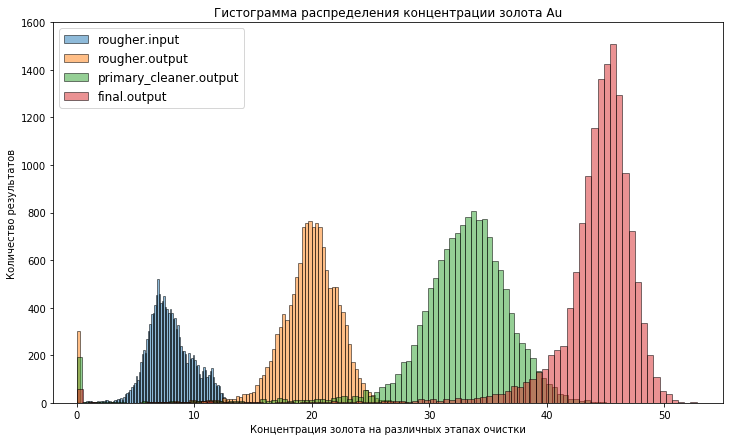

In [29]:
plt.figure(figsize=[12,7])

plt.hist(gold_train['rougher.input.feed_au'], bins=100, label = 'rougher.input', alpha=.5, ec='black')
plt.hist(gold_train['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5, ec='black')
plt.hist(gold_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5, ec='black')
plt.hist(gold_train['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5, ec='black')

plt.xlim([-2, 55])
plt.ylim([0, 1600])

plt.xlabel('Концентрация золота на различных этапах очистки')
plt.ylabel('Количество результатов')

plt.legend(loc='upper left', fontsize='large')

plt.title('Гистограмма распределения концентрации золота Au')
plt.show()

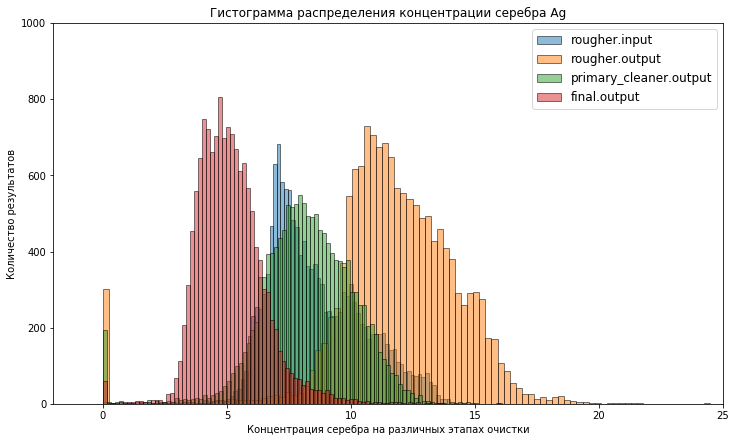

In [30]:
plt.figure(figsize=[12,7])

plt.hist(gold_train['rougher.input.feed_ag'], bins=100, label = 'rougher.input', alpha=.5, ec='black')
plt.hist(gold_train['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5, ec='black')
plt.hist(gold_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5, ec='black')
plt.hist(gold_train['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5, ec='black')

plt.xlim([-2, 25])
plt.ylim([0, 1000])

plt.xlabel('Концентрация серебра на различных этапах очистки')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='large')

plt.title('Гистограмма распределения концентрации серебра Ag')
plt.show()

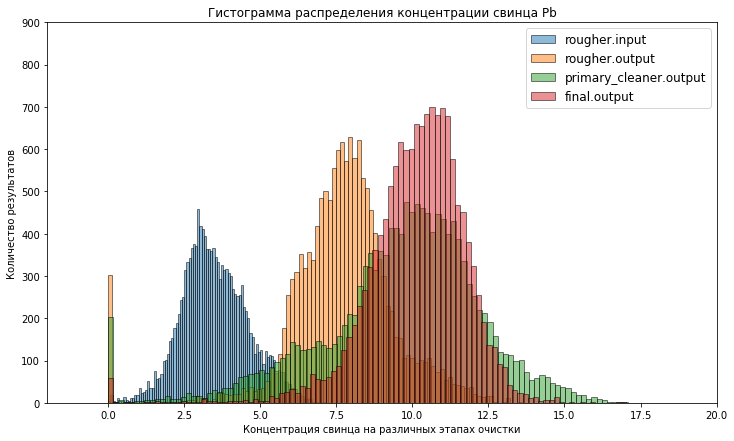

In [31]:
plt.figure(figsize=[12,7])

plt.hist(gold_train['rougher.input.feed_pb'], bins=100, label = 'rougher.input', alpha=.5, ec='black')
plt.hist(gold_train['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5, ec='black')
plt.hist(gold_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5, ec='black')
plt.hist(gold_train['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5, ec='black')

plt.xlim([-2, 20])
plt.ylim([0, 900])

plt.xlabel('Концентрация свинца на различных этапах очистки')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='large')

plt.title('Гистограмма распределения концентрации свинца Pb')
plt.show()

**ВЫВОД:**

1. Концентрация золота повышается с каждым этапом, что вполне логично, ведь цель флотации и очисток - увеличить концентрацию золота.


2. Концентрация серебра повышается после флотации, а далее снижается с каждым новым шагом очистки. 


3. Концентрация свинца повышается с этапа rougher до primary_cleaner, и потом усредняется. Это обусловлено химическими процесами очистки золота: при использование азотнокислого выщелачивания в концентрате образуется много сульфата свинца. Помимо этого, повышение концентрации свинца происходит из-за очищения других составляющих из золотоносной руды.

### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. 

Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках: если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Для сравнения построим гистограммы распределения размеров гранул сырья для обучающей и тестовой выборок.

In [32]:
# Найдем столбцы, содержащие информацию о размерах гранул
for column in gold_train:
    if 'feed_size' in column:
        print(column)

primary_cleaner.input.feed_size
rougher.input.feed_size


В данных есть значения размеров гранул для 2-х этапов - флотация и первичная очистка. Построим графики распределений для обоих этапов.

In [33]:
def feed_size_kdeplot(train_col, test_col, title, xlim, ylim):
    plt.figure(figsize=[12,7])
    
    sns.kdeplot(train_col, label = 'TRAIN', alpha=.5, shade=True)
    sns.kdeplot(test_col, label = 'TEST', alpha=.5, shade=True)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.xlabel('Размер гранул')
    plt.ylabel('Плотность вероятности непрерывной величины')

    plt.legend(loc='upper right', fontsize='large')

    plt.title(title)
    plt.show()

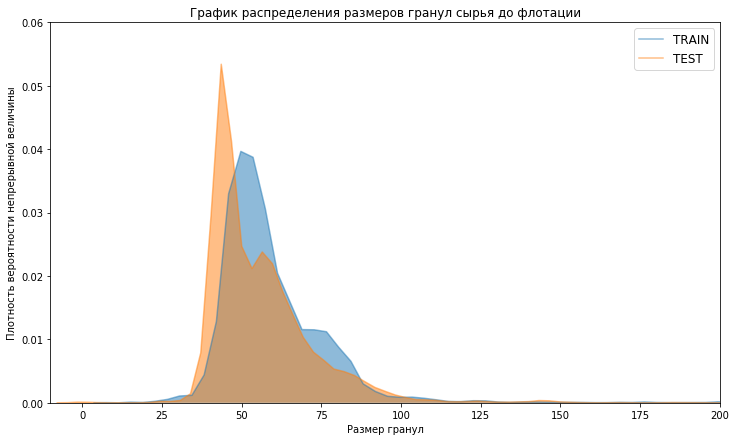

In [34]:
feed_size_kdeplot(gold_train['rougher.input.feed_size'],gold_test['rougher.input.feed_size'],\
                 'График распределения размеров гранул сырья до флотации', [-10,200], [0,0.06])

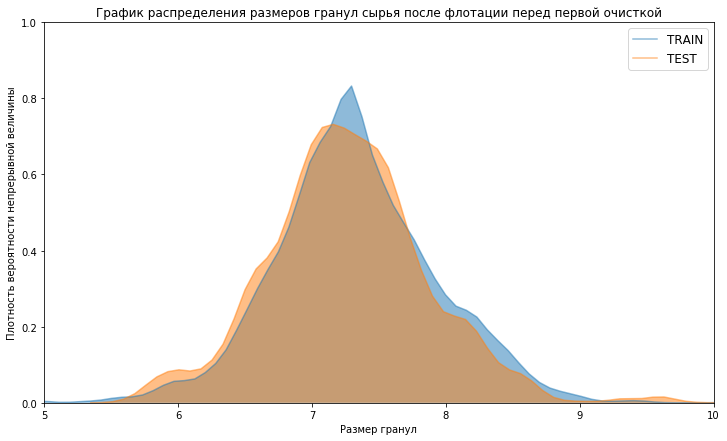

In [35]:
feed_size_kdeplot(gold_train['primary_cleaner.input.feed_size'],gold_test['primary_cleaner.input.feed_size'],\
                 'График распределения размеров гранул сырья после флотации перед первой очисткой', [5,10], [0,1])

На графиках видно, что есть заметное количество выбросов в районе 0. Удалим выбросы - гранулы сырья с размером менее 2 в обучающей выборке и заодно в полных данных.

In [36]:
drop_zero_feed_size = gold_train[(gold_train['primary_cleaner.input.feed_size'] < 2)]['date']
drop_zero_feed_size_input = gold_train[(gold_train['rougher.input.feed_size'] < 2)]['date']
gold_train = gold_train.query('date not in @drop_zero_feed_size')
gold_train = gold_train.query('date not in @drop_zero_feed_size_input')

drop_zero_feed_size_full = gold_full[(gold_full['primary_cleaner.input.feed_size'] < 2)]['date']
drop_zero_feed_size_input = gold_full[(gold_full['rougher.input.feed_size'] < 2)]['date']
gold_full = gold_full.query('date not in @drop_zero_feed_size_full')
gold_full = gold_full.query('date not in @drop_zero_feed_size_input')

Построим проверочные графики

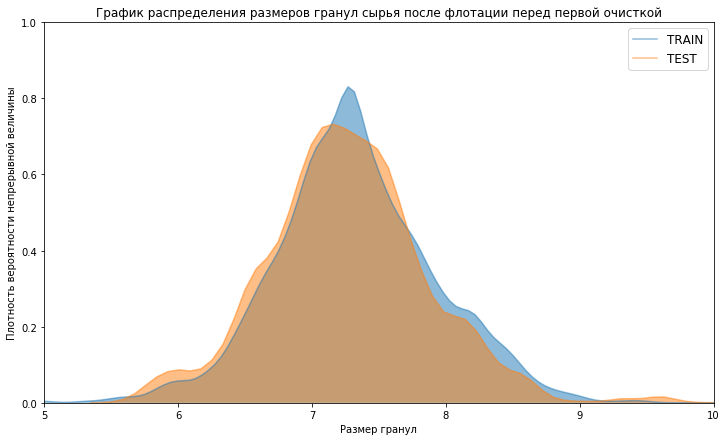

In [37]:
feed_size_kdeplot(gold_train['primary_cleaner.input.feed_size'],gold_test['primary_cleaner.input.feed_size'],\
                 'График распределения размеров гранул сырья после флотации перед первой очисткой', [5,10], [0,1])

In [38]:
gold_train['primary_cleaner.input.feed_size'].sort_values()

6235     4.97
6239     4.97
6240     4.97
6241     4.97
6243     4.97
        ...  
7053     9.50
2349    10.10
2350    10.10
1391    10.47
1392    10.47
Name: primary_cleaner.input.feed_size, Length: 14141, dtype: float64


**ВЫВОД:** 

На графике до флотации видно, что размеры гранул сырья на обучающей и тестовой выборках распределены нормально со средним в районе 45 для тестовой и в районе 50 для обучающей. Также заметны сильные выбросы на обучаюшей выборке(гранулы размером более 250) и нулевые размеры гранул в тестовой выборке.

На гистограмме после флотации обе выборки также распределены нормально со средним около 7.5 в обоих случаях.

В целом, можно заключить, что распределения не сильно отличаются друг от друга, а значит, модель будет работать корректно.

### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Исследуем суммарную концентрацию металлов на разных стадиях: 
  - в сырье, 
  - в черновом концентрате, 
  - в концентрате после первой очистки,
  - в финальном концентрате.

In [39]:
# Найдем все столбцы с данными о концентрациях вещества. 
# Из них нам интересны стадия флотации и финальный концентрат.
for column in gold_full:
    if 'concentrate_' in column:
        print(column)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au


In [40]:
# Найдем все столбцы с данными по предварительной стадии(сырьё). 
# Из этого списка потребуются столбцы с данными о металлах
for column in gold_full:
    if 'rougher.input.feed_' in column:
        print(column)

rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au


In [41]:
# Найдем суммарные концентрации всех веществ для каждого из этапов:

sum_final_output_concentrate = gold_full[['final.output.concentrate_ag',\
                                           'final.output.concentrate_pb',\
                                           'final.output.concentrate_sol',\
                                           'final.output.concentrate_au']].sum(axis=1)

sum_primary_cleaner_output_concentrate = gold_full[['primary_cleaner.output.concentrate_ag',\
                                                     'primary_cleaner.output.concentrate_pb',\
                                                     'primary_cleaner.output.concentrate_sol',\
                                                     'primary_cleaner.output.concentrate_au']].sum(axis=1)

sum_rougher_output_concentrate = gold_full[['rougher.output.concentrate_ag',\
                                             'rougher.output.concentrate_pb',\
                                             'rougher.output.concentrate_sol',\
                                             'rougher.output.concentrate_au']].sum(axis=1)

sum_rougher_input_feed_concentrate = gold_full[['rougher.input.feed_ag',\
                                                'rougher.input.feed_pb',\
                                                'rougher.input.feed_sol',\
                                                'rougher.input.feed_au']].sum(axis=1)


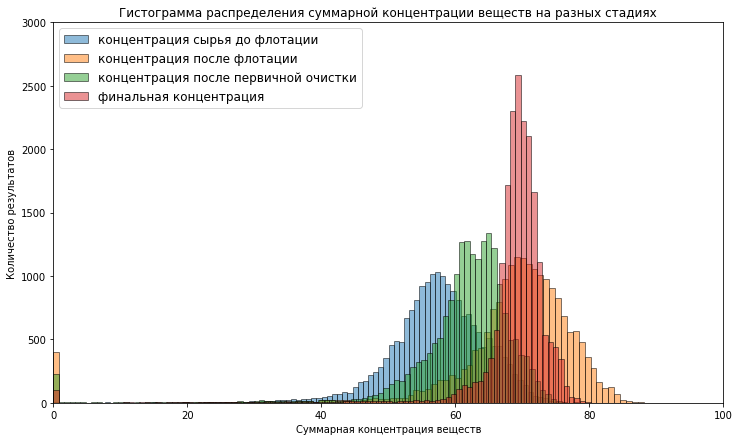

In [42]:
plt.figure(figsize=[12,7])

plt.hist(sum_rougher_input_feed_concentrate, bins=100, label = 'концентрация сырья до флотации', alpha=.5, ec='black')
plt.hist(sum_rougher_output_concentrate, bins=100, label = 'концентрация после флотации', alpha=.5, ec='black')
plt.hist(sum_primary_cleaner_output_concentrate, bins=100, label = 'концентрация после первичной очистки', alpha=.5, ec='black')
plt.hist(sum_final_output_concentrate, bins=100, label = 'финальная концентрация', alpha=.5, ec='black')

plt.xlim([0, 100])
plt.ylim([0, 3000])

plt.xlabel('Суммарная концентрация веществ')
plt.ylabel('Количество результатов')

plt.legend(loc='upper left', fontsize='large')

plt.title('Гистограмма распределения суммарной концентрации веществ на разных стадиях')
plt.show()

На графике видно, что есть заметное количество выбросов в районе 0. Приблизим график.

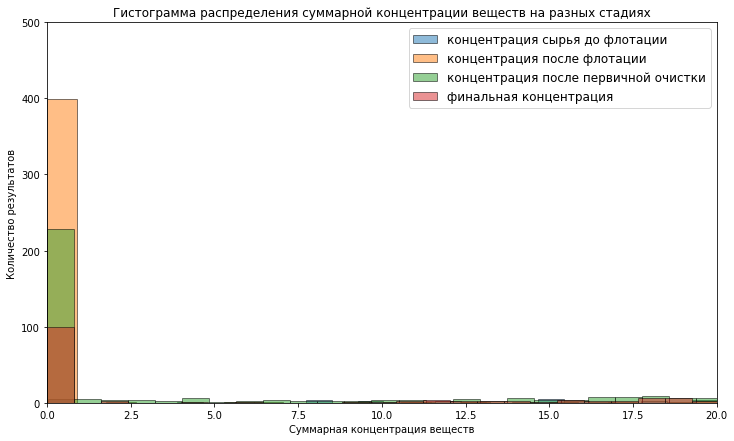

In [43]:
plt.figure(figsize=[12,7])

plt.hist(sum_rougher_input_feed_concentrate, bins=100, label = 'концентрация сырья до флотации', alpha=.5, ec='black')
plt.hist(sum_rougher_output_concentrate, bins=100, label = 'концентрация после флотации', alpha=.5, ec='black')
plt.hist(sum_primary_cleaner_output_concentrate, bins=100, label = 'концентрация после первичной очистки', alpha=.5, ec='black')
plt.hist(sum_final_output_concentrate, bins=100, label = 'финальная концентрация', alpha=.5, ec='black')

plt.xlim([0, 20])
plt.ylim([0, 500])

plt.xlabel('Суммарная концентрация веществ')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='large')

plt.title('Гистограмма распределения суммарной концентрации веществ на разных стадиях')
plt.show()

На графиках хорошо видно, что во всех распределениях (кроме сырья) присутствует пик около нулевого значения. Эти нулевые значения следует удалить, поскольку они, во первых, очень далеки от общего распределения, а во вторых, нулевые суммарные концентрации вещества в контексте рассматриваемой задачи - это вообще как-то не логично. Возможно, это ошибочные данные. 

#### Удаление нулевых значений.

In [44]:
# Создадим список столбцов, в которых нужно удалить нулевые концентрации
zero_columns_list=[]

for column in gold_full:
    if 'concentrate_' in column:
        zero_columns_list.append(column)
        

print(zero_columns_list)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']


In [45]:
# Выведем количества нулей в столбцах
for column in zero_columns_list:
    print()
    print('FULL: количество нулей в столбце:',column, '-', gold_full.loc[gold_full.loc[:,column] == 0][column].count())   
    print('TRAIN: количество нулей в столбце:',column, '-', gold_train.loc[gold_train.loc[:,column] == 0][column].count()) 
    print()


FULL: количество нулей в столбце: final.output.concentrate_ag - 98
TRAIN: количество нулей в столбце: final.output.concentrate_ag - 58


FULL: количество нулей в столбце: final.output.concentrate_pb - 98
TRAIN: количество нулей в столбце: final.output.concentrate_pb - 58


FULL: количество нулей в столбце: final.output.concentrate_sol - 98
TRAIN: количество нулей в столбце: final.output.concentrate_sol - 58


FULL: количество нулей в столбце: final.output.concentrate_au - 98
TRAIN: количество нулей в столбце: final.output.concentrate_au - 58


FULL: количество нулей в столбце: primary_cleaner.output.concentrate_ag - 108
TRAIN: количество нулей в столбце: primary_cleaner.output.concentrate_ag - 74


FULL: количество нулей в столбце: primary_cleaner.output.concentrate_pb - 114
TRAIN: количество нулей в столбце: primary_cleaner.output.concentrate_pb - 79


FULL: количество нулей в столбце: primary_cleaner.output.concentrate_sol - 116
TRAIN: количество нулей в столбце: primary_cleaner.out

In [46]:
# Количество нулей в целевых признаках из gold_full

print('Количество нулей в столбце',column,':',
      gold_full.loc[gold_full.loc[:,'rougher.output.recovery'] == 0][column].count())
print('Количество нулей в столбце',column,':', 
      gold_full.loc[gold_full.loc[:,'final.output.recovery'] == 0][column].count())

Количество нулей в столбце rougher.output.concentrate_au : 394
Количество нулей в столбце rougher.output.concentrate_au : 98


In [47]:
# Удаляем нули в столбцах с концентрациями золота Au
drop_zero_date = gold_full[(gold_full['final.output.concentrate_au'] == 0) |\
                           (gold_full['primary_cleaner.output.concentrate_au'] == 0) |\
                           (gold_full['rougher.output.concentrate_au'] == 0)]['date']

gold_full = gold_full.query('date not in @drop_zero_date')
gold_train = gold_train.query('date not in @drop_zero_date')
gold_test = gold_test.query('date not in @drop_zero_date')

In [48]:
print('После удаления нулевых значений в столбцах с концентрациями золота Au:')
print()
print('Размеры выборки gold_full:', gold_full.shape)
print('Размеры выборки gold_train:', gold_train.shape)
print('Размеры выборки gold_test:', gold_test.shape)

После удаления нулевых значений в столбцах с концентрациями золота Au:

Размеры выборки gold_full: (18836, 87)
Размеры выборки gold_train: (13717, 87)
Размеры выборки gold_test: (5123, 55)


In [49]:
# Удаляем нули в столбцах с концентрациями серебра Ag
drop_zero_date_ag = gold_full[(gold_full['final.output.concentrate_ag'] == 0) |\
                           (gold_full['primary_cleaner.output.concentrate_ag'] == 0) |\
                           (gold_full['rougher.output.concentrate_ag'] == 0)]['date']

gold_full = gold_full.query('date not in @drop_zero_date_ag')
gold_train = gold_train.query('date not in @drop_zero_date_ag')
gold_test = gold_test.query('date not in @drop_zero_date_ag')

In [50]:
print('После удаления нулевых значений в столбцах с концентрациями серебра Ag:')
print()
print('Размеры выборки gold_full:', gold_full.shape)
print('Размеры выборки gold_train:', gold_train.shape)
print('Размеры выборки gold_test:', gold_test.shape)

После удаления нулевых значений в столбцах с концентрациями серебра Ag:

Размеры выборки gold_full: (18836, 87)
Размеры выборки gold_train: (13717, 87)
Размеры выборки gold_test: (5123, 55)


In [51]:
# Удаляем нули в столбцах с концентрациями свинца Pb
drop_zero_date_pb = gold_full[(gold_full['final.output.concentrate_pb'] == 0) |\
                           (gold_full['primary_cleaner.output.concentrate_pb'] == 0) |\
                           (gold_full['rougher.output.concentrate_pb'] == 0)]['date']

gold_full = gold_full.query('date not in @drop_zero_date_pb')
gold_train = gold_train.query('date not in @drop_zero_date_pb')
gold_test = gold_test.query('date not in @drop_zero_date_pb')

In [52]:
print('После удаления нулевых значений в столбцах с концентрациями свинца Pb:')
print()
print('Размеры выборки gold_full:', gold_full.shape)
print('Размеры выборки gold_train:', gold_train.shape)
print('Размеры выборки gold_test:', gold_test.shape)

После удаления нулевых значений в столбцах с концентрациями свинца Pb:

Размеры выборки gold_full: (18830, 87)
Размеры выборки gold_train: (13712, 87)
Размеры выборки gold_test: (5122, 55)


In [53]:
# Удаляем нули в столбцах с концентрациями солей sol
drop_zero_date_sol = gold_full[(gold_full['final.output.concentrate_sol'] == 0) |\
                           (gold_full['primary_cleaner.output.concentrate_sol'] == 0) |\
                           (gold_full['rougher.output.concentrate_sol'] == 0)]['date']

gold_full = gold_full.query('date not in @drop_zero_date_sol')
gold_train = gold_train.query('date not in @drop_zero_date_sol')
gold_test = gold_test.query('date not in @drop_zero_date_sol')

In [54]:
print('После удаления нулевых значений в столбцах с концентрациями солей sol:')
print()
print('Размеры выборки gold_full:', gold_full.shape)
print('Размеры выборки gold_train:', gold_train.shape)
print('Размеры выборки gold_test:', gold_test.shape)

После удаления нулевых значений в столбцах с концентрациями солей sol:

Размеры выборки gold_full: (18826, 87)
Размеры выборки gold_train: (13708, 87)
Размеры выборки gold_test: (5122, 55)


Относительно весомо размер датафрейма меняется только после удаления нулевых концентраций золота. При удалении нулевых концентраций всех остальных веществ уходит всего по 1-2 строки данных.

Посмотрим, как выглядит распределение после удаления нулевых значений.

In [55]:
sum_final_output_concentrate = gold_full[['final.output.concentrate_ag',\
                                           'final.output.concentrate_pb',\
                                           'final.output.concentrate_sol',\
                                           'final.output.concentrate_au']].sum(axis=1)

sum_primary_cleaner_output_concentrate = gold_full[['primary_cleaner.output.concentrate_ag',\
                                                     'primary_cleaner.output.concentrate_pb',\
                                                     'primary_cleaner.output.concentrate_sol',\
                                                     'primary_cleaner.output.concentrate_au']].sum(axis=1)

sum_rougher_output_concentrate = gold_full[['rougher.output.concentrate_ag',\
                                             'rougher.output.concentrate_pb',\
                                             'rougher.output.concentrate_sol',\
                                             'rougher.output.concentrate_au']].sum(axis=1)

sum_rougher_input_feed_concentrate = gold_full[['rougher.input.feed_ag',\
                                                'rougher.input.feed_pb',\
                                                'rougher.input.feed_sol',\
                                                'rougher.input.feed_au']].sum(axis=1)

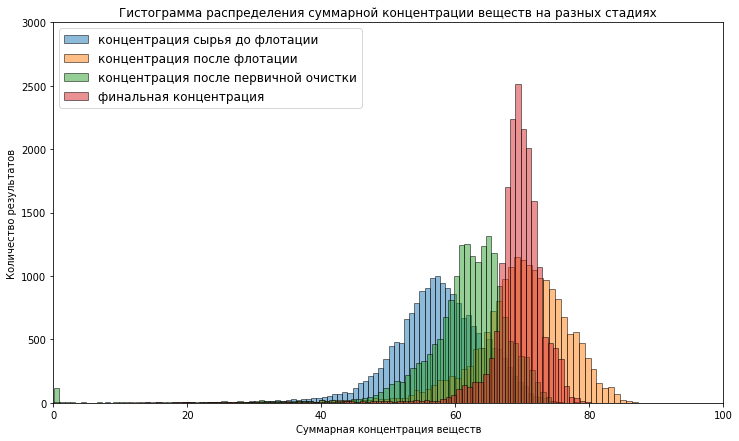

In [56]:
plt.figure(figsize=[12,7])

plt.hist(sum_rougher_input_feed_concentrate, bins=100, label = 'концентрация сырья до флотации', alpha=.5, ec='black')
plt.hist(sum_rougher_output_concentrate, bins=100, label = 'концентрация после флотации', alpha=.5, ec='black')
plt.hist(sum_primary_cleaner_output_concentrate, bins=100, label = 'концентрация после первичной очистки', alpha=.5, ec='black')
plt.hist(sum_final_output_concentrate, bins=100, label = 'финальная концентрация', alpha=.5, ec='black')

plt.xlim([0, 100])
plt.ylim([0, 3000])

plt.xlabel('Суммарная концентрация веществ')
plt.ylabel('Количество результатов')

plt.legend(loc='upper left', fontsize='large')

plt.title('Гистограмма распределения суммарной концентрации веществ на разных стадиях')
plt.show()

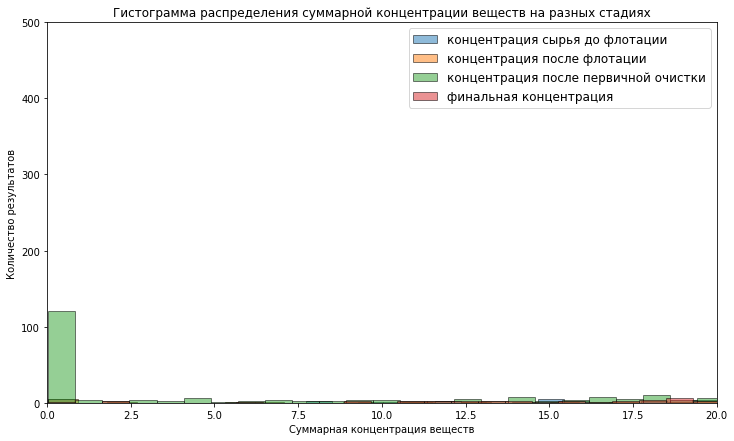

In [57]:
plt.figure(figsize=[12,7])

plt.hist(sum_rougher_input_feed_concentrate, bins=100, label = 'концентрация сырья до флотации', alpha=.5, ec='black')
plt.hist(sum_rougher_output_concentrate, bins=100, label = 'концентрация после флотации', alpha=.5, ec='black')
plt.hist(sum_primary_cleaner_output_concentrate, bins=100, label = 'концентрация после первичной очистки', alpha=.5, ec='black')
plt.hist(sum_final_output_concentrate, bins=100, label = 'финальная концентрация', alpha=.5, ec='black')

plt.xlim([0, 20])
plt.ylim([0, 500])

plt.xlabel('Суммарная концентрация веществ')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='large')

plt.title('Гистограмма распределения суммарной концентрации веществ на разных стадиях')
plt.show()

In [58]:
# Проверим околонулевые значения концентраций, которые показывает график
primary_cleaner_output_concentrate = ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au',\
                                     'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol']

for column in primary_cleaner_output_concentrate:
    print(column,':\n',gold_full[column].sort_values().head(5))
    print()
    print(gold_full[column].value_counts().head(5))
    print()
    print('##################################################')
    print()

primary_cleaner.output.concentrate_ag :
 17290    0.01
19003    0.01
17931    0.01
17930    0.01
16004    0.01
Name: primary_cleaner.output.concentrate_ag, dtype: float64

0.010000    117
8.339732      6
7.925334      5
9.987871      5
7.355843      3
Name: primary_cleaner.output.concentrate_ag, dtype: int64

##################################################

primary_cleaner.output.concentrate_au :
 17308    0.01
16262    0.01
15811    0.01
16263    0.01
19003    0.01
Name: primary_cleaner.output.concentrate_au, dtype: float64

0.010000     117
30.350809      6
36.306431      5
27.765463      5
31.847486      3
Name: primary_cleaner.output.concentrate_au, dtype: int64

##################################################

primary_cleaner.output.concentrate_pb :
 17302    0.01
17318    0.01
17282    0.01
17317    0.01
18507    0.01
Name: primary_cleaner.output.concentrate_pb, dtype: float64

0.010000     118
5.055124       7
10.952148      6
11.327148      6
14.202148      6
Name: primar

На стадии первичной очистки остались суммарные концентрации, равные 0.01 - по всего 117-118 значений для каждого вещества. Поскольку они ничтожно малы, а также носят характер выбросов (расположены сильно в стороне от гистограммы), удалим их.

In [59]:
drop_zero_primary_cleaner_output_date = gold_full[(gold_full['primary_cleaner.output.concentrate_ag'] < 1) |\
                           (gold_full['primary_cleaner.output.concentrate_pb'] < 1) |\
                           (gold_full['primary_cleaner.output.concentrate_au'] < 1) |\
                           (gold_full['primary_cleaner.output.concentrate_sol'] < 1)]['date']

gold_full = gold_full.query('date not in @drop_zero_primary_cleaner_output_date')
gold_train = gold_train.query('date not in @drop_zero_primary_cleaner_output_date')
gold_test = gold_test.query('date not in @drop_zero_primary_cleaner_output_date')

In [60]:
primary_cleaner_output_concentrate = ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au',\
                                     'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol']

for column in primary_cleaner_output_concentrate:
    print(column,':\n',gold_full[column].sort_values().head(5))
    print()
    print(gold_full[column].value_counts().head(5))
    print()
    print('##################################################')
    print()
    print()

primary_cleaner.output.concentrate_ag :
 18195    1.012395
1080     1.125056
15417    1.126822
75       1.174961
5939     1.186319
Name: primary_cleaner.output.concentrate_ag, dtype: float64

8.339732    6
9.987871    5
7.925334    5
7.355843    3
9.526259    2
Name: primary_cleaner.output.concentrate_ag, dtype: int64

##################################################


primary_cleaner.output.concentrate_au :
 15417    2.991256
8242     3.916086
14916    4.116963
18195    4.697498
13780    4.820178
Name: primary_cleaner.output.concentrate_au, dtype: float64

30.350809    6
27.765463    5
36.306431    5
31.847486    3
33.581341    2
Name: primary_cleaner.output.concentrate_au, dtype: int64

##################################################


primary_cleaner.output.concentrate_pb :
 15417    1.254637
2899     1.280987
2900     1.280987
2884     1.378359
2920     1.381204
Name: primary_cleaner.output.concentrate_pb, dtype: float64

5.055124     7
10.952148    6
11.327148    6
14.202148 

**ВЫВОД:**

Проведено исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Суммарная концентрация возрастает с каждым этапом, достигая максимума на финальном этапе.

Обнаруженные нулевые и околонулевые значения суммарных концентраций определены как выбросы и удалены, поскольку их наличие в данных может ухудшить качество предсказания моделей.

## 3. Модели.

### 3.1. Функция для вычисления итоговой sMAPE.

**Метрика качества**

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

In [65]:
display(Image(url='https://pictures.s3.yandex.net/resources/smape_1576238825.jpg', width=500))

где:

    y[i] - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
    
    ^y[i] - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
    
    N - количество объектов в выборке

Нужно спрогнозировать сразу две величины:

   - эффективность обогащения чернового концентрата rougher.output.recovery;
   
   - эффективность обогащения финального концентрата final.output.recovery.
   
   
Итоговая метрика складывается из двух величин:

In [66]:
display(Image(url='https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg', width=500))

In [67]:
# Создадим функцию для подсчета метрики sMAPE
def sMAPE(y_true, y_pred):
    sMAPE = np.mean(abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2))*100
    return sMAPE   

In [68]:
# Создадим функцию для подсчета итоговой метрики
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

### 3.2.  Обучение моделей.

Перед обучением необходимо из обучающей выборки удалить лишние столбцы, которых нет в тестовой. Также из обеих выборок необходимо удалить утолбец `date`. В тестовую выборку нужно было добавить целевые признаки - это мы уже сделали в пункте 1.4

In [69]:
train = gold_train.loc[:, gold_test.columns]
train = train.drop(['date'], axis=1)

test = gold_test.drop(['date'], axis=1)

Обучим следующие модели регрессии:
    - Случайный лес
    - Линейная регрессия
    - Дерево решений
    - Лассо
    - KNeighborsRegressor

In [70]:
RANDOM_STATE = 42

# Делим признаки на фичи и таргет:
X_train_rougher = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_rougher = train['rougher.output.recovery']
X_train_final = X_train_rougher
y_train_final = train['final.output.recovery']

# Масштабируем признаки:
scaler = StandardScaler()
scaler.fit(X_train_rougher)
scaler.fit(X_train_final)

X_train_rougher = scaler.transform(X_train_rougher)
X_train_final = scaler.transform(X_train_final)

**Случайный лес**

In [71]:
%%time

# Зададим параметры модели:

model = RandomForestRegressor()
NEW_SCORE = make_scorer(sMAPE, greater_is_better=False)
param_grid = {'n_estimators': range(10, 31, 5),
              'max_depth': range(1,10,2),
              'min_samples_leaf': range(1,3),
              'min_samples_split': range(2,4)
              }


grid_rougher_RF = GridSearchCV(model, param_grid, scoring=NEW_SCORE, n_jobs=-1, verbose=10, cv=3)


# Обучаем модель для train_rougher:
grid_rougher_RF.fit(X_train_rougher, y_train_rougher)

best_grid_rougher_RF = grid_rougher_RF.best_estimator_
best_sMAPE_rougher_RF = grid_rougher_RF.best_score_

print('best_sMAPE_rougher_RF:', -1*(best_sMAPE_rougher_RF))
print(best_grid_rougher_RF)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

best_sMAPE_rougher_RF: 7.695830683236861
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Wall time: 6min 56s


In [72]:
%%time

grid_final_RF = GridSearchCV(model, param_grid, scoring=NEW_SCORE, n_jobs=-1, verbose=10, cv=3)

# Обучаем модель для train_final:
grid_final_RF.fit(X_train_final, y_train_final)

best_grid_final_RF = grid_final_RF.best_estimator_
best_sMAPE_final_RF = grid_final_RF.best_score_

print('best_sMAPE_final_RF:', -1*(best_sMAPE_final_RF))
print(best_grid_final_RF)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

best_sMAPE_final_RF: 9.794304639987041
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Wall time: 6min 45s


In [73]:
best_final_sMAPE_RF = final_sMAPE(best_sMAPE_rougher_RF,best_sMAPE_final_RF)
print('Лучшее значение метрики final_sMAPE для модели RandomForestRegressor:', -1*(best_final_sMAPE_RF).round(4))

Лучшее значение метрики final_sMAPE для модели RandomForestRegressor: 9.2697


**Линейная регрессия**

In [74]:
def linear_regr_model(X, y):
    model = LinearRegression()
    result = cross_val_score(model, X, y, scoring=NEW_SCORE, cv=3)
    return result.mean()

In [75]:
sMAPE_rougher_LR = linear_regr_model(X_train_rougher, y_train_rougher)
sMAPE_final_LR = linear_regr_model(X_train_final, y_train_final)

print('sMAPE_rougher_LR:', -1*(sMAPE_rougher_LR).round(4))
print('sMAPE_final_LR:', -1*(sMAPE_final_LR).round(4))
print()
best_final_sMAPE_LR = final_sMAPE(sMAPE_rougher_LR, sMAPE_final_LR)
print('Лучшее значение метрики final_sMAPE для модели LinearRegression:', -1*(best_final_sMAPE_LR).round(4))

sMAPE_rougher_LR: 10.4244
sMAPE_final_LR: 13.2761

Лучшее значение метрики final_sMAPE для модели LinearRegression: 12.5632


Обучим линейную регрессию на трейн-сетах, очищенных от мультиколлинеарности.

In [76]:
# Удалим столбец 'date'
gold_train_multicorr_drop_1 = gold_train_multicorr_drop_1.drop(['date'], axis=1)
gold_train_multicorr_drop_2 = gold_train_multicorr_drop_2.drop(['date'], axis=1)

In [77]:
# Обучение на датасете gold_train_multicorr_drop_1
X_train_rougher_multicorr_drop_1 = gold_train_multicorr_drop_1.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_rougher_multicorr_drop_1 = gold_train_multicorr_drop_1['rougher.output.recovery']
X_train_final_multicorr_drop_1 = X_train_rougher_multicorr_drop_1
y_train_final_multicorr_drop_1 = gold_train_multicorr_drop_1['final.output.recovery']

# Масштабируем признаки:
scaler = StandardScaler()
scaler.fit(X_train_rougher_multicorr_drop_1)
scaler.fit(X_train_final_multicorr_drop_1)

X_train_rougher_multicorr_drop_1 = scaler.transform(X_train_rougher_multicorr_drop_1)
X_train_final_multicorr_drop_1 = scaler.transform(X_train_final_multicorr_drop_1)

sMAPE_rougher_LR_multicorr_drop_1 = linear_regr_model(X_train_rougher_multicorr_drop_1, y_train_rougher_multicorr_drop_1)
sMAPE_final_LR_multicorr_drop_1 = linear_regr_model(X_train_final_multicorr_drop_1, y_train_final_multicorr_drop_1)

print('sMAPE_rougher_LR_multicorr_drop_1:', -1*(sMAPE_rougher_LR_multicorr_drop_1).round(4))
print('sMAPE_final_LR_multicorr_drop_1:', -1*(sMAPE_final_LR_multicorr_drop_1).round(4))
print()
best_final_sMAPE_LR_multicorr_drop_1 = final_sMAPE(sMAPE_rougher_LR_multicorr_drop_1, sMAPE_final_LR_multicorr_drop_1)
print('Лучшее значение метрики final_sMAPE для модели LinearRegression на датасете gold_train_multicorr_drop_1:',\
      -1*(best_final_sMAPE_LR_multicorr_drop_1).round(4))

sMAPE_rougher_LR_multicorr_drop_1: 13.3593
sMAPE_final_LR_multicorr_drop_1: 5.5441

Лучшее значение метрики final_sMAPE для модели LinearRegression на датасете gold_train_multicorr_drop_1: 7.4979


In [78]:
# Обучение на датасете gold_train_multicorr_drop_2

X_train_rougher_multicorr_drop_2 = gold_train_multicorr_drop_2.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_rougher_multicorr_drop_2 = gold_train_multicorr_drop_2['rougher.output.recovery']
X_train_final_multicorr_drop_2 = X_train_rougher_multicorr_drop_2
y_train_final_multicorr_drop_2 = gold_train_multicorr_drop_2['final.output.recovery']

# Масштабируем признаки:
#pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(X_train_rougher_multicorr_drop_2)
scaler.fit(X_train_final_multicorr_drop_2)

X_train_rougher_multicorr_drop_2 = scaler.transform(X_train_rougher_multicorr_drop_2)
X_train_final_multicorr_drop_2 = scaler.transform(X_train_final_multicorr_drop_2)

sMAPE_rougher_LR_multicorr_drop_2 = linear_regr_model(X_train_rougher_multicorr_drop_2, y_train_rougher_multicorr_drop_2)
sMAPE_final_LR_multicorr_drop_2 = linear_regr_model(X_train_final_multicorr_drop_2, y_train_final_multicorr_drop_2)

print('sMAPE_rougher_LR_multicorr_drop_2:', -1*(sMAPE_rougher_LR_multicorr_drop_2).round(4))
print('sMAPE_final_LR_multicorr_drop_2:', -1*(sMAPE_final_LR_multicorr_drop_2).round(4))
print()
best_final_sMAPE_LR_multicorr_drop_2 = final_sMAPE(sMAPE_rougher_LR_multicorr_drop_2, sMAPE_final_LR_multicorr_drop_2)
print('Лучшее значение метрики final_sMAPE для модели LinearRegression на датасете gold_train_multicorr_drop_2:',\
      -1*(best_final_sMAPE_LR_multicorr_drop_2).round(4))

sMAPE_rougher_LR_multicorr_drop_2: 13.8301
sMAPE_final_LR_multicorr_drop_2: 10.099

Лучшее значение метрики final_sMAPE для модели LinearRegression на датасете gold_train_multicorr_drop_2: 11.0318


In [79]:
result_LR_table = pd.DataFrame({'model':['LinearRegression','LinearRegression','LinearRegression'],\
                                'dataset':['gold_train', 'gold_train_multicorr_drop_1', 'gold_train_multicorr_drop_2'],\
                                'best_final_sMAPE':[-1*(best_final_sMAPE_LR).round(4), -1*(best_final_sMAPE_LR_multicorr_drop_1).round(4),\
                                                    -1*(best_final_sMAPE_LR_multicorr_drop_2).round(4)]
                                })

result_LR_table

model                      dataset  best_final_sMAPE
0  LinearRegression                   gold_train           12.5632
1  LinearRegression  gold_train_multicorr_drop_1            7.4979
2  LinearRegression  gold_train_multicorr_drop_2           11.0318

**ВЫВОД:** 

Обучение на выборке после удаления коррелирующих признаков заметно улучшило качество линейной регрессии: значение ошибки упало с 12.56 для исходного сета до 7.50 для сета №1. При обучении на сете №2 ошибка также уменьшилась, но не так сильно: с 12.56 до 11.03

**Дерево решений**

In [80]:
%%time


model = DecisionTreeRegressor()
param_grid = {'max_depth': range(1,16), 'min_samples_leaf': range(1,5), 'min_samples_split': range(2,6)}

grid_rougher_DT = GridSearchCV(model, param_grid, scoring=NEW_SCORE, n_jobs=-1, verbose=10, cv=3)
grid_final_DT = GridSearchCV(model, param_grid, scoring=NEW_SCORE, n_jobs=-1, verbose=10, cv=3)

# Обучаем модели
grid_rougher_DT.fit(X_train_rougher, y_train_rougher)
grid_final_DT.fit(X_train_final, y_train_final)

best_grid_rougher_DT = grid_rougher_DT.best_estimator_
best_sMAPE_rougher_DT =grid_rougher_DT.best_score_

best_grid_final_DT = grid_final_DT.best_estimator_
best_sMAPE_final_DT =grid_final_DT.best_score_


print('best_sMAPE_rougher_DT:', -1*(best_sMAPE_rougher_DT).round(4))
print(best_grid_rougher_DT)

print()
print()

print('best_sMAPE_final_DT:', -1*(best_sMAPE_final_DT).round(4))
print(best_grid_final_DT)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1633s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0078s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.8s
[Parallel(n_jo

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1406s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0028s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:   16.9s
[Parallel(n_jo

best_sMAPE_rougher_DT: 7.7772
DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


best_sMAPE_final_DT: 10.1138
DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
Wall time: 24min 11s


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 21.9min finished


In [81]:
best_final_sMAPE_DT = final_sMAPE(best_sMAPE_rougher_DT, best_sMAPE_final_DT)
print('Лучшее значение метрики final_sMAPE для модели DecisionTreeRegressor:', -1*(best_final_sMAPE_DT).round(4))

Лучшее значение метрики final_sMAPE для модели DecisionTreeRegressor: 9.5296


**Модель Лассо**

In [82]:
%%time

model = linear_model.Lasso()
param_grid = {'alpha': [0.1, 1, 0.05], 'selection': ['cyclic', 'random']}

grid_rougher_L = GridSearchCV(model, param_grid, scoring=NEW_SCORE)
grid_final_L = GridSearchCV(model, param_grid, scoring=NEW_SCORE)

grid_rougher_L.fit(X_train_rougher, y_train_rougher)
grid_final_L.fit(X_train_final, y_train_final)

best_grid_rougher_L = grid_rougher_L.best_estimator_
best_sMAPE_rougher_L =grid_rougher_L.best_score_

best_grid_final_L = grid_final_L.best_estimator_
best_sMAPE_final_L =grid_final_L.best_score_


print('best_sMAPE_rougher_L:', -1*(best_sMAPE_rougher_L).round(4))
print(best_grid_rougher_L)

print()
print()

print('best_sMAPE_final_L:', -1*(best_sMAPE_final_L).round(4))
print(best_grid_final_L)


best_sMAPE_rougher_L: 8.2333
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='random', tol=0.0001, warm_start=False)


best_sMAPE_final_L: 9.7122
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
Wall time: 3.3 s


In [83]:
best_final_sMAPE_L = final_sMAPE(best_sMAPE_rougher_L, best_sMAPE_final_L)
print('Лучшее значение метрики final_sMAPE для модели Lasso:', -1*(best_final_sMAPE_L).round(4))

Лучшее значение метрики final_sMAPE для модели Lasso: 9.3424


**KNeighbors**

In [84]:
%%time

model = KNeighborsRegressor()
param_grid = {'n_neighbors': range(40,71,2), 'weights': ['uniform', 'distance']}


grid_rougher_KN = GridSearchCV(model, param_grid, scoring=NEW_SCORE, n_jobs=-1, verbose=10, cv=3)
grid_final_KN = GridSearchCV(model, param_grid, scoring=NEW_SCORE, n_jobs=-1, verbose=10, cv=3)

# Обучаем модели
grid_rougher_KN.fit(X_train_rougher, y_train_rougher)
grid_final_KN.fit(X_train_final, y_train_final)

best_grid_rougher_KN = grid_rougher_KN.best_estimator_
best_sMAPE_rougher_KN = grid_rougher_KN.best_score_

best_grid_final_KN = grid_final_KN.best_estimator_
best_sMAPE_final_KN = grid_final_KN.best_score_

print('best_sMAPE_rougher_KN:', -1*(best_sMAPE_rougher_KN).round(4))
print(best_grid_rougher_KN)

print()
print()

print('best_sMAPE_final_KN:', -1*(best_sMAPE_final_KN).round(4))
print(best_grid_final_KN)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.1min


best_sMAPE_rougher_KN: 8.5092
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=70, p=2,
                    weights='uniform')


best_sMAPE_final_KN: 11.627
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=70, p=2,
                    weights='uniform')
Wall time: 9min 49s


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.9min finished


In [85]:
best_final_sMAPE_KN = final_sMAPE(best_sMAPE_rougher_KN, best_sMAPE_final_KN)
print('Лучшее значение метрики final_sMAPE для модели KNeighborsRegressor:', -1*(best_final_sMAPE_KN).round(4))

Лучшее значение метрики final_sMAPE для модели KNeighborsRegressor: 10.8476


**Результирующая таблица.**

In [94]:
result_table = pd.DataFrame({'model':['RandomForestRegressor','LinearRegression', 'LinearRegression_dataset1',\
                                      'LinearRegression_dataset2', 'DecisionTreeRegressor','Lasso', 'KNeighborsRegressor'],
                            'best_final_sMAPE':[abs(best_final_sMAPE_RF).round(4), abs(best_final_sMAPE_LR).round(4),\
                                                abs(best_final_sMAPE_LR_multicorr_drop_1).round(4),\
                                                abs(best_final_sMAPE_LR_multicorr_drop_2).round(4), abs(best_final_sMAPE_DT).round(4),\
                                                abs(best_final_sMAPE_L).round(4), abs(best_final_sMAPE_KN).round(4)]
                            })

result_table.sort_values(by='best_final_sMAPE').reset_index(drop=True)

model  best_final_sMAPE
0  LinearRegression_dataset1            7.4979
1      RandomForestRegressor            9.2697
2                      Lasso            9.3424
3      DecisionTreeRegressor            9.5296
4        KNeighborsRegressor           10.8476
5  LinearRegression_dataset2           11.0318
6           LinearRegression           12.5632

**ВЫВОД:**

Минимальное значение final_sMAPE=7.4979 даёт модель  LinearRegression, обученная на варианте №1 датасета, очищенного от мультиколлинеарности. 

Второе место у модели RandomForestRegressor со значением final_sMAPE=9.2697.

В случае нашей задачи за корреляцией скрывается технологический процесс, и при удалении хотя бы одного звена есть вероятность, что упадёт вся цепочка. Без обсуждения этого момента с заказчиком нет уверенности, что удаление части данных - это корректный подход. 

Поэтому в качестве лучшей примем модель RandomForestRegressor со значением final_sMAPE=9.2697 и именно ее поверим на тестовой выборке.

### Проверка модели на тестовой выборке

**Проверка модели RandomForestRegressor**

In [95]:
# Делим признаки на фичи и таргет:
X_test_rougher = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test_rougher = test['rougher.output.recovery']
X_test_final = X_test_rougher
y_test_final = test['final.output.recovery']


In [97]:
y_test_rougher_predicted = best_grid_rougher_RF.predict(X_test_rougher)
sMAPE_rougher_test_RF = sMAPE(y_test_rougher, y_test_rougher_predicted)

y_test_final_predicted = best_grid_final_RF.predict(X_test_final)
sMAPE_final_test_RF = sMAPE(y_test_final, y_test_final_predicted)

print('sMAPE_rougher_test_RF:', sMAPE_rougher_test_RF)
print('sMAPE_final_test_RF:', sMAPE_final_test_RF)

sMAPE_rougher_test_RF: 4.526549586492562
sMAPE_final_test_RF: 7.723366399181421


In [99]:
final_sMAPE_test_RF = final_sMAPE(sMAPE_rougher_test_RF, sMAPE_final_test_RF)
print('Значение метрики final_sMAPE модели RandomForestRegressor на тестовой выборке:', final_sMAPE_test_RF)

Значение метрики final_sMAPE модели RandomForestRegressor на тестовой выборке: 6.924162196009206


### Проверка на константной модели

In [101]:
dummy_clf_model = DummyRegressor(strategy='median')

dummy_clf_model.fit(X_train_rougher, y_train_rougher)
y_test_rougher_predicted = dummy_clf_model.predict(X_test_rougher)

dummy_clf_model.fit(X_train_final, y_train_final)
y_test_final_predicted = dummy_clf_model.predict(X_test_final)

sMAPE_rougher_Dummy = sMAPE(y_test_rougher, y_test_rougher_predicted)
sMAPE_final_Dummy = sMAPE(y_test_final, y_test_final_predicted)

print('sMAPE_rougher_Dummy:', sMAPE_rougher_Dummy)
print('sMAPE_final_Dummy:', sMAPE_final_Dummy)


sMAPE_rougher_Dummy: 4.767200575369245
sMAPE_final_Dummy: 8.172888551591189


In [102]:
final_sMAPE_test_Dummy = final_sMAPE(sMAPE_rougher_Dummy, sMAPE_final_Dummy)
final_sMAPE_test_Dummy

7.321466557535703

Модель прошла проверку на адекватность, поскольку полученная на тесте ошибка (6.9242) меньше, чем на константной модели (7.3215).

In [103]:
best_grid_rougher_RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [104]:
best_grid_final_RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## ВЫВОД

1. Итоговая модель построена на алгоритме RandomForestRegressor 
2. Ошибка на тестовой выборке: 6.9242
3. Параметры алгоритма: 
     - для таргета `rougher.output.recovery`:
     
                      RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=15,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
                      
     - для таргета `final.output.recovery`:
     
                      RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
